In [1]:
import torch
import torch.nn as nn
import yaml
import torch.distributions as distributions
import torch.optim as optim
from critic import Criticnet, SmallMLP
from scorenet import Scorenet
import os
from datasets import toy_data
import numpy as np 
import matplotlib
from utils import keep_grad, approx_jacobian_trace, exact_jacobian_trace, \
    set_random_seed, get_logger, dict2namespace, get_opt, visualize_2d, langevin_dynamics_lsd
import importlib
import argparse
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config_file = './test_config_toy_2d.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


Namespace(data=Namespace(batch_size=1, cates=None, data_dir=None, dataset_scale=1, dataset_type='pinwheel', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='pinwheel'), inference=Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1), log=Namespace(log_freq=10, save_dir='log/test-toy-2d', save_freq=200, val_freq=100, viz_freq=100), models=Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=1

In [3]:
def sample_data(data, n_points):
    x = toy_data.inf_train_gen(data, n_points=n_points)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    return x

In [4]:
score_net = SmallMLP(n_dims=2, n_out=2)
critic_net = SmallMLP(n_dims=2, n_out=2)

critic_net.to(device)
score_net.to(device)

opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

k_iters = 10
e_iters = 5
epochs = 3000
itr = 0
for epoch in range(epochs):
    tr_pts = sample_data('pinwheel', 2048).view(-1, 2)
    
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()

    tr_pts.requires_grad_()
    batch_size = tr_pts.size(0)

    perturbed_points = tr_pts

    score_pred = score_net(perturbed_points)

    critic_output = critic_net(perturbed_points)

    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)

    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()

    cycle_iter = itr % (k_iters + e_iters)

    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()

    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        log_message = "Epoch %d (critic), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)
    else:
        loss.backward()
        opt_scorenet.step()
        log_message = "Epoch %d (score), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)

    print(log_message)
    itr += 1

#     if itr % cfg.log.save_freq == 0:
#         score_net.cpu()

#         torch.save({
#             'args': args,
#             'state_dict': score_net.state_dict(),
#         }, os.path.join(cfg.log.save_dir, 'checkpt.pth'))

#         score_net.to(device)

#     if itr % cfg.log.viz_freq == 0:
#         plt.clf()

#         #pt_cl, _ = langevin_dynamics(score_net, sigmas, dim=2, eps=1e-4, num_steps=cfg.inference.num_steps)
#         x_final = langevin_dynamics_lsd(score_net, l=1., e=.01, num_points=2048, n_steps=10)

#         visualize_2d(x_final)

#         fig_filename = os.path.join(cfg.log.save_dir, 'figs', 'sample-{:04d}.png'.format(itr))
#         os.makedirs(os.path.dirname(fig_filename), exist_ok=True)
#         plt.savefig(fig_filename)


#         visualize_2d(perturbed_points)

#         fig_filename = os.path.join(cfg.log.save_dir, 'figs', 'perturbed-{:04d}.png'.format(itr))
#         os.makedirs(os.path.dirname(fig_filename), exist_ok=True)
#         plt.savefig(fig_filename)

#     itr += 1

Epoch 0 (critic), Loss=-0.01868 t1=-0.00177 t2=-0.01691
Epoch 1 (critic), Loss=0.33995 t1=-0.00555 t2=0.34550
Epoch 2 (critic), Loss=0.62822 t1=-0.00697 t2=0.63519
Epoch 3 (critic), Loss=0.75648 t1=-0.00713 t2=0.76361
Epoch 4 (critic), Loss=0.73324 t1=-0.00619 t2=0.73942
Epoch 5 (critic), Loss=0.64409 t1=-0.00259 t2=0.64668
Epoch 6 (critic), Loss=0.53470 t1=-0.00200 t2=0.53670
Epoch 7 (critic), Loss=0.43072 t1=-0.00194 t2=0.43267
Epoch 8 (critic), Loss=0.35642 t1=-0.00265 t2=0.35907
Epoch 9 (critic), Loss=0.32176 t1=-0.00348 t2=0.32524
Epoch 10 (score), Loss=0.32205 t1=-0.00475 t2=0.32680
Epoch 11 (score), Loss=0.20412 t1=-0.11929 t2=0.32341
Epoch 12 (score), Loss=0.08324 t1=-0.24161 t2=0.32485
Epoch 13 (score), Loss=-0.04038 t1=-0.36589 t2=0.32551
Epoch 14 (score), Loss=-0.17010 t1=-0.49546 t2=0.32536
Epoch 15 (critic), Loss=-0.30577 t1=-0.63269 t2=0.32692
Epoch 16 (critic), Loss=-0.15034 t1=-0.36389 t2=0.21355
Epoch 17 (critic), Loss=0.06492 t1=0.02057 t2=0.04435
Epoch 18 (critic), L

Epoch 159 (critic), Loss=1.06989 t1=0.00444 t2=1.06545
Epoch 160 (score), Loss=1.10318 t1=-0.03006 t2=1.13324
Epoch 161 (score), Loss=1.11613 t1=-0.02901 t2=1.14513
Epoch 162 (score), Loss=1.13208 t1=-0.03793 t2=1.17001
Epoch 163 (score), Loss=1.08888 t1=-0.02001 t2=1.10889
Epoch 164 (score), Loss=1.09749 t1=-0.01682 t2=1.11431
Epoch 165 (critic), Loss=1.09571 t1=-0.06441 t2=1.16012
Epoch 166 (critic), Loss=1.12515 t1=-0.08786 t2=1.21301
Epoch 167 (critic), Loss=1.12266 t1=-0.12174 t2=1.24441
Epoch 168 (critic), Loss=1.17144 t1=-0.15770 t2=1.32914
Epoch 169 (critic), Loss=1.17377 t1=-0.16457 t2=1.33834
Epoch 170 (critic), Loss=1.19669 t1=-0.10444 t2=1.30112
Epoch 171 (critic), Loss=1.21452 t1=-0.13400 t2=1.34852
Epoch 172 (critic), Loss=1.23128 t1=-0.10391 t2=1.33519
Epoch 173 (critic), Loss=1.20166 t1=-0.09247 t2=1.29413
Epoch 174 (critic), Loss=1.25503 t1=-0.06468 t2=1.31971
Epoch 175 (score), Loss=1.29055 t1=-0.09282 t2=1.38337
Epoch 176 (score), Loss=1.24473 t1=-0.09684 t2=1.34158


Epoch 317 (critic), Loss=4.40059 t1=0.06660 t2=4.33399
Epoch 318 (critic), Loss=4.95604 t1=0.12782 t2=4.82821
Epoch 319 (critic), Loss=5.05637 t1=0.13985 t2=4.91652
Epoch 320 (critic), Loss=5.09824 t1=0.30837 t2=4.78988
Epoch 321 (critic), Loss=5.08670 t1=0.34906 t2=4.73765
Epoch 322 (critic), Loss=5.24932 t1=0.36833 t2=4.88099
Epoch 323 (critic), Loss=5.04379 t1=0.37381 t2=4.66998
Epoch 324 (critic), Loss=4.99891 t1=0.33128 t2=4.66763
Epoch 325 (score), Loss=4.84811 t1=0.07740 t2=4.77071
Epoch 326 (score), Loss=4.73924 t1=0.03110 t2=4.70815
Epoch 327 (score), Loss=4.90359 t1=0.04274 t2=4.86085
Epoch 328 (score), Loss=4.72239 t1=0.03277 t2=4.68962
Epoch 329 (score), Loss=4.78140 t1=-0.00273 t2=4.78412
Epoch 330 (critic), Loss=4.54377 t1=-0.07589 t2=4.61967
Epoch 331 (critic), Loss=4.82701 t1=-0.07299 t2=4.90000
Epoch 332 (critic), Loss=5.14036 t1=0.02261 t2=5.11774
Epoch 333 (critic), Loss=5.48370 t1=0.21606 t2=5.26763
Epoch 334 (critic), Loss=5.49997 t1=0.21599 t2=5.28398
Epoch 335 (c

Epoch 477 (score), Loss=8.57178 t1=-0.02459 t2=8.59637
Epoch 478 (score), Loss=8.48004 t1=-0.05640 t2=8.53644
Epoch 479 (score), Loss=8.72302 t1=-0.06349 t2=8.78651
Epoch 480 (critic), Loss=8.38160 t1=-0.15566 t2=8.53726
Epoch 481 (critic), Loss=8.62687 t1=-0.04710 t2=8.67397
Epoch 482 (critic), Loss=8.93539 t1=0.03334 t2=8.90205
Epoch 483 (critic), Loss=9.08172 t1=0.09287 t2=8.98885
Epoch 484 (critic), Loss=8.85056 t1=-0.05207 t2=8.90263
Epoch 485 (critic), Loss=8.86243 t1=-0.11052 t2=8.97296
Epoch 486 (critic), Loss=8.99316 t1=-0.15603 t2=9.14919
Epoch 487 (critic), Loss=8.94723 t1=-0.12235 t2=9.06958
Epoch 488 (critic), Loss=8.90725 t1=-0.07260 t2=8.97985
Epoch 489 (critic), Loss=9.09275 t1=0.08231 t2=9.01045
Epoch 490 (score), Loss=9.05433 t1=0.07898 t2=8.97536
Epoch 491 (score), Loss=9.20776 t1=0.01845 t2=9.18932
Epoch 492 (score), Loss=9.24643 t1=-0.03368 t2=9.28010
Epoch 493 (score), Loss=9.25769 t1=-0.08339 t2=9.34108
Epoch 494 (score), Loss=8.89548 t1=-0.10652 t2=9.00200
Epoch

Epoch 636 (critic), Loss=11.64783 t1=-0.19304 t2=11.84087
Epoch 637 (critic), Loss=12.03414 t1=-0.15653 t2=12.19067
Epoch 638 (critic), Loss=11.63213 t1=-0.37268 t2=12.00481
Epoch 639 (critic), Loss=11.83211 t1=-0.27594 t2=12.10805
Epoch 640 (score), Loss=12.08126 t1=-0.23263 t2=12.31389
Epoch 641 (score), Loss=11.88144 t1=-0.26433 t2=12.14577
Epoch 642 (score), Loss=12.03307 t1=-0.16112 t2=12.19419
Epoch 643 (score), Loss=11.84363 t1=-0.16712 t2=12.01075
Epoch 644 (score), Loss=11.92078 t1=-0.26717 t2=12.18796
Epoch 645 (critic), Loss=12.06946 t1=-0.34623 t2=12.41570
Epoch 646 (critic), Loss=12.03762 t1=-0.22462 t2=12.26225
Epoch 647 (critic), Loss=11.99784 t1=-0.18371 t2=12.18155
Epoch 648 (critic), Loss=11.89001 t1=-0.13852 t2=12.02853
Epoch 649 (critic), Loss=12.03777 t1=-0.11995 t2=12.15772
Epoch 650 (critic), Loss=11.95888 t1=-0.17120 t2=12.13008
Epoch 651 (critic), Loss=12.26290 t1=-0.10889 t2=12.37179
Epoch 652 (critic), Loss=12.00954 t1=-0.11343 t2=12.12297
Epoch 653 (critic),

Epoch 795 (critic), Loss=13.48915 t1=-0.37466 t2=13.86382
Epoch 796 (critic), Loss=13.29465 t1=-0.34295 t2=13.63761
Epoch 797 (critic), Loss=13.45587 t1=-0.30046 t2=13.75633
Epoch 798 (critic), Loss=13.45050 t1=-0.05740 t2=13.50790
Epoch 799 (critic), Loss=13.84674 t1=0.23805 t2=13.60869
Epoch 800 (critic), Loss=13.53198 t1=-0.09715 t2=13.62912
Epoch 801 (critic), Loss=13.73415 t1=0.08977 t2=13.64439
Epoch 802 (critic), Loss=13.44851 t1=-0.02778 t2=13.47629
Epoch 803 (critic), Loss=13.34860 t1=-0.14590 t2=13.49450
Epoch 804 (critic), Loss=13.39869 t1=-0.12821 t2=13.52690
Epoch 805 (score), Loss=13.38935 t1=-0.10964 t2=13.49898
Epoch 806 (score), Loss=13.21463 t1=0.00052 t2=13.21411
Epoch 807 (score), Loss=13.49824 t1=0.06561 t2=13.43263
Epoch 808 (score), Loss=13.45121 t1=-0.04857 t2=13.49979
Epoch 809 (score), Loss=13.43362 t1=-0.09201 t2=13.52563
Epoch 810 (critic), Loss=13.08453 t1=-0.29381 t2=13.37834
Epoch 811 (critic), Loss=13.53597 t1=-0.00538 t2=13.54135
Epoch 812 (critic), Los

Epoch 955 (score), Loss=14.75005 t1=0.70599 t2=14.04406
Epoch 956 (score), Loss=14.71809 t1=0.45564 t2=14.26244
Epoch 957 (score), Loss=14.48742 t1=0.49927 t2=13.98815
Epoch 958 (score), Loss=14.61188 t1=0.44947 t2=14.16241
Epoch 959 (score), Loss=14.24255 t1=0.06787 t2=14.17467
Epoch 960 (critic), Loss=13.80511 t1=-0.40477 t2=14.20988
Epoch 961 (critic), Loss=13.65053 t1=-0.67576 t2=14.32628
Epoch 962 (critic), Loss=14.05723 t1=-0.35552 t2=14.41275
Epoch 963 (critic), Loss=14.12540 t1=-0.40271 t2=14.52811
Epoch 964 (critic), Loss=14.17139 t1=-0.18457 t2=14.35596
Epoch 965 (critic), Loss=13.76150 t1=-0.32090 t2=14.08239
Epoch 966 (critic), Loss=13.67778 t1=-0.33607 t2=14.01384
Epoch 967 (critic), Loss=13.93054 t1=-0.47083 t2=14.40138
Epoch 968 (critic), Loss=14.13235 t1=-0.10143 t2=14.23378
Epoch 969 (critic), Loss=13.97333 t1=-0.19953 t2=14.17286
Epoch 970 (score), Loss=13.89539 t1=-0.41788 t2=14.31328
Epoch 971 (score), Loss=13.87009 t1=-0.20023 t2=14.07032
Epoch 972 (score), Loss=14

Epoch 1115 (critic), Loss=14.53407 t1=0.00112 t2=14.53295
Epoch 1116 (critic), Loss=14.86365 t1=0.44540 t2=14.41825
Epoch 1117 (critic), Loss=14.91896 t1=0.65366 t2=14.26530
Epoch 1118 (critic), Loss=14.94590 t1=0.62020 t2=14.32570
Epoch 1119 (critic), Loss=14.44631 t1=0.29559 t2=14.15072
Epoch 1120 (score), Loss=14.23525 t1=0.14484 t2=14.09041
Epoch 1121 (score), Loss=14.74390 t1=0.27448 t2=14.46942
Epoch 1122 (score), Loss=14.37639 t1=0.17328 t2=14.20311
Epoch 1123 (score), Loss=14.28908 t1=0.17439 t2=14.11469
Epoch 1124 (score), Loss=14.37962 t1=-0.30273 t2=14.68235
Epoch 1125 (critic), Loss=13.87932 t1=-0.28185 t2=14.16117
Epoch 1126 (critic), Loss=14.35814 t1=-0.27675 t2=14.63488
Epoch 1127 (critic), Loss=15.01268 t1=0.00447 t2=15.00822
Epoch 1128 (critic), Loss=15.36662 t1=-0.00638 t2=15.37301
Epoch 1129 (critic), Loss=15.26436 t1=-0.03098 t2=15.29535
Epoch 1130 (critic), Loss=14.73315 t1=-0.11573 t2=14.84888
Epoch 1131 (critic), Loss=14.79446 t1=-0.12499 t2=14.91945
Epoch 1132 (

Epoch 1275 (critic), Loss=14.02876 t1=-0.32203 t2=14.35079
Epoch 1276 (critic), Loss=15.46668 t1=0.62811 t2=14.83857
Epoch 1277 (critic), Loss=16.91956 t1=1.68120 t2=15.23836
Epoch 1278 (critic), Loss=18.05153 t1=2.22619 t2=15.82534
Epoch 1279 (critic), Loss=17.62476 t1=1.77128 t2=15.85348
Epoch 1280 (critic), Loss=16.73629 t1=1.12092 t2=15.61537
Epoch 1281 (critic), Loss=16.08175 t1=0.61745 t2=15.46430
Epoch 1282 (critic), Loss=15.03974 t1=0.01271 t2=15.02703
Epoch 1283 (critic), Loss=14.59367 t1=-0.46016 t2=15.05383
Epoch 1284 (critic), Loss=14.76662 t1=-0.02241 t2=14.78903
Epoch 1285 (score), Loss=15.58906 t1=0.43332 t2=15.15575
Epoch 1286 (score), Loss=15.28399 t1=0.16360 t2=15.12040
Epoch 1287 (score), Loss=15.02614 t1=-0.06448 t2=15.09062
Epoch 1288 (score), Loss=14.63019 t1=-0.24630 t2=14.87648
Epoch 1289 (score), Loss=14.46170 t1=-0.66123 t2=15.12293
Epoch 1290 (critic), Loss=13.99976 t1=-1.00476 t2=15.00451
Epoch 1291 (critic), Loss=15.29121 t1=-0.12790 t2=15.41911
Epoch 1292 

Epoch 1435 (score), Loss=16.41522 t1=1.54808 t2=14.86714
Epoch 1436 (score), Loss=16.50255 t1=1.57937 t2=14.92318
Epoch 1437 (score), Loss=15.15278 t1=0.37206 t2=14.78072
Epoch 1438 (score), Loss=14.88970 t1=0.20258 t2=14.68711
Epoch 1439 (score), Loss=14.51129 t1=-0.35379 t2=14.86508
Epoch 1440 (critic), Loss=13.51362 t1=-1.28235 t2=14.79597
Epoch 1441 (critic), Loss=14.41065 t1=-0.53241 t2=14.94306
Epoch 1442 (critic), Loss=16.01654 t1=1.27711 t2=14.73943
Epoch 1443 (critic), Loss=18.34285 t1=3.84141 t2=14.50144
Epoch 1444 (critic), Loss=20.45387 t1=6.18045 t2=14.27342
Epoch 1445 (critic), Loss=21.36594 t1=7.49656 t2=13.86938
Epoch 1446 (critic), Loss=21.37732 t1=7.56851 t2=13.80881
Epoch 1447 (critic), Loss=20.80569 t1=6.95128 t2=13.85440
Epoch 1448 (critic), Loss=18.96341 t1=5.16296 t2=13.80045
Epoch 1449 (critic), Loss=17.24728 t1=3.28226 t2=13.96502
Epoch 1450 (score), Loss=16.49565 t1=2.07319 t2=14.42245
Epoch 1451 (score), Loss=16.40286 t1=1.79488 t2=14.60798
Epoch 1452 (score)

Epoch 1595 (critic), Loss=16.57031 t1=1.54597 t2=15.02434
Epoch 1596 (critic), Loss=17.46519 t1=2.21181 t2=15.25337
Epoch 1597 (critic), Loss=18.16076 t1=2.71205 t2=15.44871
Epoch 1598 (critic), Loss=18.68225 t1=2.94550 t2=15.73674
Epoch 1599 (critic), Loss=18.63279 t1=2.86188 t2=15.77091
Epoch 1600 (score), Loss=18.73316 t1=2.68249 t2=16.05067
Epoch 1601 (score), Loss=18.38519 t1=2.40255 t2=15.98264
Epoch 1602 (score), Loss=17.76637 t1=1.96570 t2=15.80067
Epoch 1603 (score), Loss=17.77665 t1=1.87578 t2=15.90087
Epoch 1604 (score), Loss=17.14824 t1=1.38363 t2=15.76461
Epoch 1605 (critic), Loss=17.13697 t1=1.02883 t2=16.10814
Epoch 1606 (critic), Loss=16.55509 t1=0.57454 t2=15.98055
Epoch 1607 (critic), Loss=15.73230 t1=-0.24745 t2=15.97975
Epoch 1608 (critic), Loss=15.55012 t1=-0.50002 t2=16.05015
Epoch 1609 (critic), Loss=14.88022 t1=-0.71833 t2=15.59855
Epoch 1610 (critic), Loss=15.08854 t1=-0.67249 t2=15.76103
Epoch 1611 (critic), Loss=15.55241 t1=-0.40636 t2=15.95877
Epoch 1612 (cr

Epoch 1755 (critic), Loss=14.65790 t1=-1.11419 t2=15.77210
Epoch 1756 (critic), Loss=14.17935 t1=-1.17746 t2=15.35681
Epoch 1757 (critic), Loss=14.34409 t1=-1.15144 t2=15.49553
Epoch 1758 (critic), Loss=14.15060 t1=-1.36922 t2=15.51982
Epoch 1759 (critic), Loss=14.60650 t1=-1.18317 t2=15.78968
Epoch 1760 (critic), Loss=14.13619 t1=-1.32460 t2=15.46079
Epoch 1761 (critic), Loss=14.51723 t1=-1.35476 t2=15.87199
Epoch 1762 (critic), Loss=14.38688 t1=-1.41389 t2=15.80077
Epoch 1763 (critic), Loss=14.48167 t1=-1.16339 t2=15.64506
Epoch 1764 (critic), Loss=14.40271 t1=-1.15223 t2=15.55494
Epoch 1765 (score), Loss=14.38503 t1=-1.15861 t2=15.54364
Epoch 1766 (score), Loss=14.15765 t1=-1.05799 t2=15.21563
Epoch 1767 (score), Loss=14.10130 t1=-1.36483 t2=15.46613
Epoch 1768 (score), Loss=14.15886 t1=-1.27764 t2=15.43649
Epoch 1769 (score), Loss=14.14583 t1=-1.46336 t2=15.60919
Epoch 1770 (critic), Loss=14.10340 t1=-1.62213 t2=15.72553
Epoch 1771 (critic), Loss=14.03036 t1=-1.43517 t2=15.46552
Ep

Epoch 1895 (critic), Loss=13.77441 t1=-1.45804 t2=15.23246
Epoch 1896 (critic), Loss=13.84817 t1=-1.55164 t2=15.39981
Epoch 1897 (critic), Loss=13.94022 t1=-1.46386 t2=15.40409
Epoch 1898 (critic), Loss=13.90327 t1=-1.43194 t2=15.33521
Epoch 1899 (critic), Loss=14.05393 t1=-1.21909 t2=15.27302
Epoch 1900 (score), Loss=13.80139 t1=-1.34196 t2=15.14334
Epoch 1901 (score), Loss=13.92175 t1=-1.21850 t2=15.14024
Epoch 1902 (score), Loss=13.39038 t1=-1.61956 t2=15.00994
Epoch 1903 (score), Loss=13.78516 t1=-1.38407 t2=15.16923
Epoch 1904 (score), Loss=13.45743 t1=-1.73828 t2=15.19571
Epoch 1905 (critic), Loss=13.31207 t1=-1.80664 t2=15.11871
Epoch 1906 (critic), Loss=13.60388 t1=-1.48037 t2=15.08425
Epoch 1907 (critic), Loss=14.45995 t1=-0.83732 t2=15.29727
Epoch 1908 (critic), Loss=15.06138 t1=-0.30506 t2=15.36644
Epoch 1909 (critic), Loss=15.49313 t1=0.02163 t2=15.47150
Epoch 1910 (critic), Loss=15.15610 t1=-0.28062 t2=15.43672
Epoch 1911 (critic), Loss=14.88938 t1=-0.29877 t2=15.18815
Epo

Epoch 2055 (critic), Loss=13.21894 t1=-1.50669 t2=14.72562
Epoch 2056 (critic), Loss=13.30388 t1=-1.68041 t2=14.98430
Epoch 2057 (critic), Loss=13.85515 t1=-0.73800 t2=14.59315
Epoch 2058 (critic), Loss=14.87259 t1=0.13163 t2=14.74096
Epoch 2059 (critic), Loss=15.55745 t1=1.21469 t2=14.34276
Epoch 2060 (critic), Loss=16.15362 t1=1.88089 t2=14.27273
Epoch 2061 (critic), Loss=16.43435 t1=2.43229 t2=14.00205
Epoch 2062 (critic), Loss=16.88316 t1=2.80935 t2=14.07382
Epoch 2063 (critic), Loss=16.57299 t1=2.33814 t2=14.23485
Epoch 2064 (critic), Loss=15.56467 t1=1.30102 t2=14.26365
Epoch 2065 (score), Loss=15.33733 t1=0.91662 t2=14.42070
Epoch 2066 (score), Loss=15.50729 t1=1.03234 t2=14.47495
Epoch 2067 (score), Loss=15.10071 t1=0.83895 t2=14.26176
Epoch 2068 (score), Loss=15.29071 t1=0.79094 t2=14.49977
Epoch 2069 (score), Loss=14.59793 t1=0.39397 t2=14.20397
Epoch 2070 (critic), Loss=15.11260 t1=0.50055 t2=14.61205
Epoch 2071 (critic), Loss=14.77145 t1=0.27270 t2=14.49875
Epoch 2072 (crit

Epoch 2215 (score), Loss=15.94279 t1=0.68589 t2=15.25690
Epoch 2216 (score), Loss=15.72258 t1=0.62937 t2=15.09321
Epoch 2217 (score), Loss=15.51919 t1=0.31378 t2=15.20541
Epoch 2218 (score), Loss=15.48640 t1=0.15656 t2=15.32984
Epoch 2219 (score), Loss=15.04892 t1=-0.16431 t2=15.21323
Epoch 2220 (critic), Loss=14.36784 t1=-0.66667 t2=15.03451
Epoch 2221 (critic), Loss=13.85085 t1=-1.29494 t2=15.14579
Epoch 2222 (critic), Loss=13.76866 t1=-1.15971 t2=14.92837
Epoch 2223 (critic), Loss=13.98969 t1=-0.93212 t2=14.92181
Epoch 2224 (critic), Loss=14.43626 t1=-0.67557 t2=15.11183
Epoch 2225 (critic), Loss=14.56555 t1=-0.20314 t2=14.76869
Epoch 2226 (critic), Loss=15.31172 t1=0.31828 t2=14.99345
Epoch 2227 (critic), Loss=15.70375 t1=0.44405 t2=15.25970
Epoch 2228 (critic), Loss=15.32474 t1=0.06449 t2=15.26025
Epoch 2229 (critic), Loss=15.04623 t1=0.07535 t2=14.97087
Epoch 2230 (score), Loss=15.14511 t1=-0.03623 t2=15.18134
Epoch 2231 (score), Loss=14.87869 t1=-0.37848 t2=15.25717
Epoch 2232 (

Epoch 2375 (critic), Loss=15.05748 t1=0.62180 t2=14.43568
Epoch 2376 (critic), Loss=15.26224 t1=0.99749 t2=14.26474
Epoch 2377 (critic), Loss=15.38058 t1=0.77500 t2=14.60558
Epoch 2378 (critic), Loss=15.17551 t1=0.71534 t2=14.46017
Epoch 2379 (critic), Loss=14.79417 t1=0.21120 t2=14.58296
Epoch 2380 (score), Loss=14.09937 t1=-0.71415 t2=14.81352
Epoch 2381 (score), Loss=14.42051 t1=-0.28249 t2=14.70299
Epoch 2382 (score), Loss=14.58178 t1=-0.26687 t2=14.84865
Epoch 2383 (score), Loss=13.94566 t1=-0.78293 t2=14.72859
Epoch 2384 (score), Loss=13.85895 t1=-0.63834 t2=14.49729
Epoch 2385 (critic), Loss=13.99008 t1=-0.72288 t2=14.71296
Epoch 2386 (critic), Loss=14.20852 t1=-0.69187 t2=14.90040
Epoch 2387 (critic), Loss=14.41279 t1=-0.67662 t2=15.08940
Epoch 2388 (critic), Loss=14.18533 t1=-0.58616 t2=14.77148
Epoch 2389 (critic), Loss=14.97021 t1=0.33763 t2=14.63258
Epoch 2390 (critic), Loss=15.22487 t1=0.79150 t2=14.43337
Epoch 2391 (critic), Loss=15.15752 t1=1.04940 t2=14.10812
Epoch 2392

Epoch 2533 (score), Loss=13.44039 t1=-0.31021 t2=13.75059
Epoch 2534 (score), Loss=13.01465 t1=-0.92005 t2=13.93470
Epoch 2535 (critic), Loss=12.70740 t1=-1.12759 t2=13.83499
Epoch 2536 (critic), Loss=12.18618 t1=-1.68607 t2=13.87225
Epoch 2537 (critic), Loss=12.82909 t1=-1.31103 t2=14.14012
Epoch 2538 (critic), Loss=12.43841 t1=-1.96496 t2=14.40338
Epoch 2539 (critic), Loss=13.46259 t1=-1.31859 t2=14.78118
Epoch 2540 (critic), Loss=13.47060 t1=-1.06108 t2=14.53168
Epoch 2541 (critic), Loss=13.73990 t1=-1.16081 t2=14.90071
Epoch 2542 (critic), Loss=13.12384 t1=-1.24468 t2=14.36851
Epoch 2543 (critic), Loss=13.55359 t1=-0.81620 t2=14.36979
Epoch 2544 (critic), Loss=13.42166 t1=-0.84938 t2=14.27103
Epoch 2545 (score), Loss=12.88424 t1=-1.05596 t2=13.94020
Epoch 2546 (score), Loss=13.02330 t1=-0.79941 t2=13.82272
Epoch 2547 (score), Loss=12.42291 t1=-1.15594 t2=13.57885
Epoch 2548 (score), Loss=12.68764 t1=-1.44203 t2=14.12967
Epoch 2549 (score), Loss=12.37205 t1=-1.43371 t2=13.80576
Epoc

Epoch 2693 (critic), Loss=15.52490 t1=1.70370 t2=13.82120
Epoch 2694 (critic), Loss=15.35694 t1=1.48594 t2=13.87100
Epoch 2695 (score), Loss=15.08134 t1=1.28908 t2=13.79227
Epoch 2696 (score), Loss=14.95888 t1=1.10960 t2=13.84928
Epoch 2697 (score), Loss=14.41813 t1=0.44719 t2=13.97093
Epoch 2698 (score), Loss=14.36375 t1=0.27683 t2=14.08692
Epoch 2699 (score), Loss=13.90950 t1=-0.26589 t2=14.17539
Epoch 2700 (critic), Loss=12.77679 t1=-1.03796 t2=13.81475
Epoch 2701 (critic), Loss=11.99955 t1=-1.52573 t2=13.52529
Epoch 2702 (critic), Loss=11.99027 t1=-1.60899 t2=13.59926
Epoch 2703 (critic), Loss=12.29923 t1=-1.74800 t2=14.04724
Epoch 2704 (critic), Loss=11.98285 t1=-1.79302 t2=13.77587
Epoch 2705 (critic), Loss=11.89957 t1=-1.55358 t2=13.45315
Epoch 2706 (critic), Loss=12.04187 t1=-1.28283 t2=13.32471
Epoch 2707 (critic), Loss=12.01144 t1=-1.49855 t2=13.50998
Epoch 2708 (critic), Loss=12.15426 t1=-1.33325 t2=13.48750
Epoch 2709 (critic), Loss=12.34059 t1=-1.14884 t2=13.48944
Epoch 27

Epoch 2851 (critic), Loss=10.81631 t1=-2.74582 t2=13.56214
Epoch 2852 (critic), Loss=11.38336 t1=-2.25123 t2=13.63459
Epoch 2853 (critic), Loss=11.48443 t1=-2.02707 t2=13.51150
Epoch 2854 (critic), Loss=12.18456 t1=-1.47146 t2=13.65602
Epoch 2855 (critic), Loss=12.43388 t1=-1.30950 t2=13.74338
Epoch 2856 (critic), Loss=12.54933 t1=-1.48272 t2=14.03204
Epoch 2857 (critic), Loss=12.68406 t1=-1.26274 t2=13.94680
Epoch 2858 (critic), Loss=12.40729 t1=-1.32400 t2=13.73130
Epoch 2859 (critic), Loss=12.08276 t1=-1.45330 t2=13.53607
Epoch 2860 (score), Loss=11.74010 t1=-1.75766 t2=13.49776
Epoch 2861 (score), Loss=11.89047 t1=-1.89889 t2=13.78936
Epoch 2862 (score), Loss=11.77502 t1=-1.76549 t2=13.54051
Epoch 2863 (score), Loss=11.82623 t1=-1.57919 t2=13.40542
Epoch 2864 (score), Loss=11.56128 t1=-1.96325 t2=13.52453
Epoch 2865 (critic), Loss=11.99269 t1=-1.73484 t2=13.72753
Epoch 2866 (critic), Loss=10.90687 t1=-2.27755 t2=13.18442
Epoch 2867 (critic), Loss=11.49111 t1=-1.94177 t2=13.43287
Ep

In [5]:
import numpy as np

X = np.linspace(-4, 4, 30)
Y = np.linspace(-4, 4, 30)
grid = np.stack(np.meshgrid(X, Y), axis=-1).reshape(1, -1, 2)
grid_tensor = torch.tensor(grid).float().to(device)
grad_field = score_net(grid_tensor)
grad_field_np = grad_field.detach().cpu().numpy()

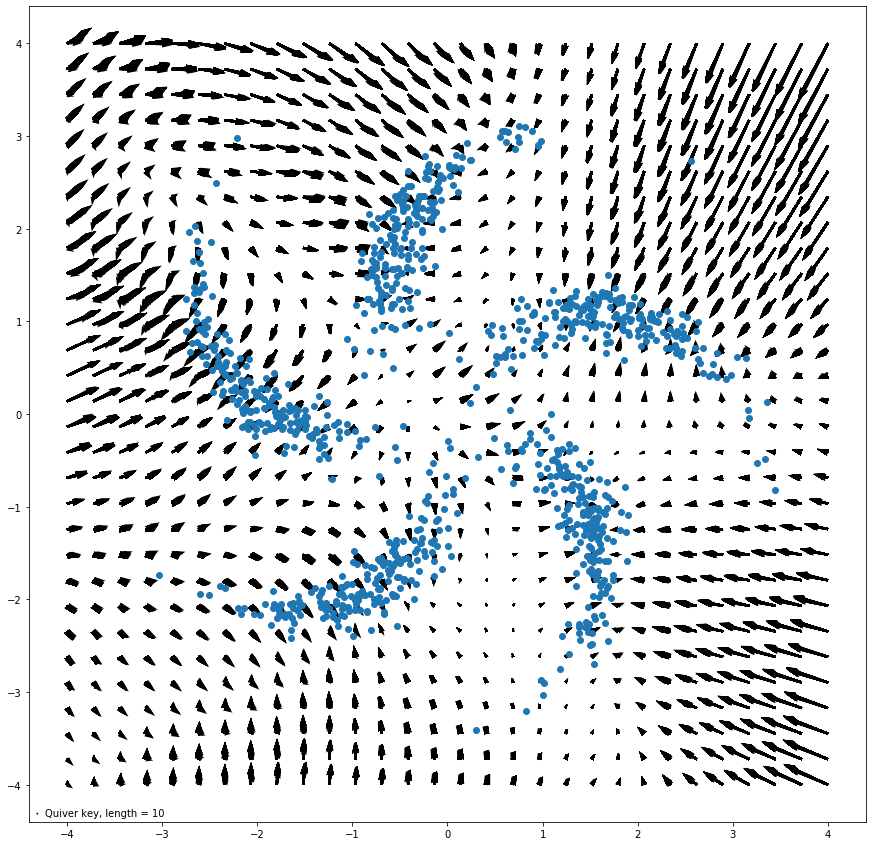

In [6]:
fig, ax = plt.subplots(figsize=(15, 15))
q = ax.quiver(grid[..., 0], grid[..., 1], grad_field_np[..., 0], grad_field_np[..., 1])
ax.quiverkey(q, X=0.01, Y=0.01, U=0.01, label='Quiver key, length = 10', labelpos='E')
sample_data = toy_data.inf_train_gen('pinwheel', n_points=1000)
ax.scatter(sample_data[:, 0], sample_data[:, 1])
plt.show()

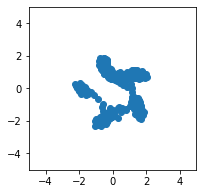

In [21]:
x_final = langevin_dynamics_lsd(score_net, l=0.01, e=.05, num_points=2048)
visualize_2d(x_final)